In [7]:
#autoreload
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import numpy as np
import featureman.gen_data as man
import featureman.utils as utils
from sklearn.cluster import SpectralClustering
import pickle
from torch.utils.data import Dataset, DataLoader
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
sae_dict = torch.load("sae_model_small_batch_2025-08-07_00-27-27.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
sae.load_state_dict(sae_dict)

model_dict = torch.load("modular_arithmetic_model.pth", map_location=device)
model = man.OneLayerTransformer(p=113, d_model=128, nheads=4).to(device)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [9]:
torch.manual_seed(1337)
# generate combination of all inputs a and b range (113)
a_values = np.arange(113)
b_values = np.arange(113)
# generate inputs for the model
inputs = np.array([[a_i, 113, b_i, 114] for a_i in a_values for b_i in b_values])
inputs = torch.tensor(inputs).to(device)  # Add batch dimension

logits, activations = model(inputs, return_activations=True)
activation_final = activations[:, -1, :].detach()
batched_acts = activation_final.unsqueeze(0).repeat(5, 1, 1).to(device)

In [16]:
import pickle

decoder = sae.W_d[3].detach() #2048 x 512

_, _, feat_acts, _ = sae(batched_acts)
features = feat_acts[3].detach() # 12769 x 512

with open("sae_clusters_small_batch_15.pkl", "rb") as f:
    clusters = pickle.load(f)
    clusters = [c for c in clusters if len(c) > 1]  # Filter out clusters with only one element

clusters = sorted(clusters, key=lambda x: len(x), reverse=True)  # Sort by size


In [33]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import warnings

# Suppress the specific PCA warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn.decomposition._pca')

data_rows = []

for i in range(len(clusters)):
    features_interest = features[:, clusters[i]]
    decoder_interest = decoder[clusters[i], :]
    reconstructions = features_interest @ decoder_interest
    
    for fixed_a in a_values:
        recon_a = reconstructions[fixed_a*113:fixed_a*113+113].detach().cpu().numpy()

        try:
            pca = PCA(n_components=6).fit(recon_a)
            output_pca = pca.transform(recon_a)
            top_freqs = utils.plot_pca_fourier_components(output_pca, plot=False)
        except:
            # If PCA fails, set everything to 0
            row_data = {
                'cluster index': i,
                'cluster size': len(clusters[i]),
                'fixed a': fixed_a,
                'pc1_cos 6': 0, 'pc1_sin 6': 0, 'pc1_cos 44': 0, 'pc1_sin 44': 0, 'pc1_cos 54': 0, 'pc1_sin 54': 0, 'pc1_other': 0,
                'pc2_cos 6': 0, 'pc2_sin 6': 0, 'pc2_cos 44': 0, 'pc2_sin 44': 0, 'pc2_cos 54': 0, 'pc2_sin 54': 0, 'pc2_other': 0
            }
            data_rows.append(row_data)
            continue
        
        # Initialize row data
        row_data = {
            'cluster index': i,
            'cluster size': len(clusters[i]),
            'fixed a': fixed_a,
            'pc1_cos 6': 0, 'pc1_sin 6': 0, 'pc1_cos 44': 0, 'pc1_sin 44': 0, 'pc1_cos 54': 0, 'pc1_sin 54': 0, 'pc1_other': 0,
            'pc2_cos 6': 0, 'pc2_sin 6': 0, 'pc2_cos 44': 0, 'pc2_sin 44': 0, 'pc2_cos 54': 0, 'pc2_sin 54': 0, 'pc2_other': 0
        }
        
        # Process PC1 (component 0) and PC2 (component 1)
        for pc_idx in [0, 1]:  # Only PC1 and PC2
            pc_name = f'pc{pc_idx + 1}'
            
            if pc_idx in top_freqs:
                component_freqs = top_freqs[pc_idx]
                for freq_info in component_freqs:
                    freq = freq_info['frequency']
                    freq_type = freq_info['type']
                    magnitude = freq_info['magnitude']
                    
                    # Check if this matches our target frequencies
                    if freq == 6 and freq_type == 'cos':
                        row_data[f'{pc_name}_cos 6'] = magnitude
                    elif freq == 6 and freq_type == 'sin':
                        row_data[f'{pc_name}_sin 6'] = magnitude
                    elif freq == 44 and freq_type == 'cos':
                        row_data[f'{pc_name}_cos 44'] = magnitude
                    elif freq == 44 and freq_type == 'sin':
                        row_data[f'{pc_name}_sin 44'] = magnitude
                    elif freq == 54 and freq_type == 'cos':
                        row_data[f'{pc_name}_cos 54'] = magnitude
                    elif freq == 54 and freq_type == 'sin':
                        row_data[f'{pc_name}_sin 54'] = magnitude
                    else:
                        row_data[f'{pc_name}_other'] += magnitude
        
        data_rows.append(row_data)

# Create DataFrame from collected data
dataframe = pd.DataFrame(data_rows)

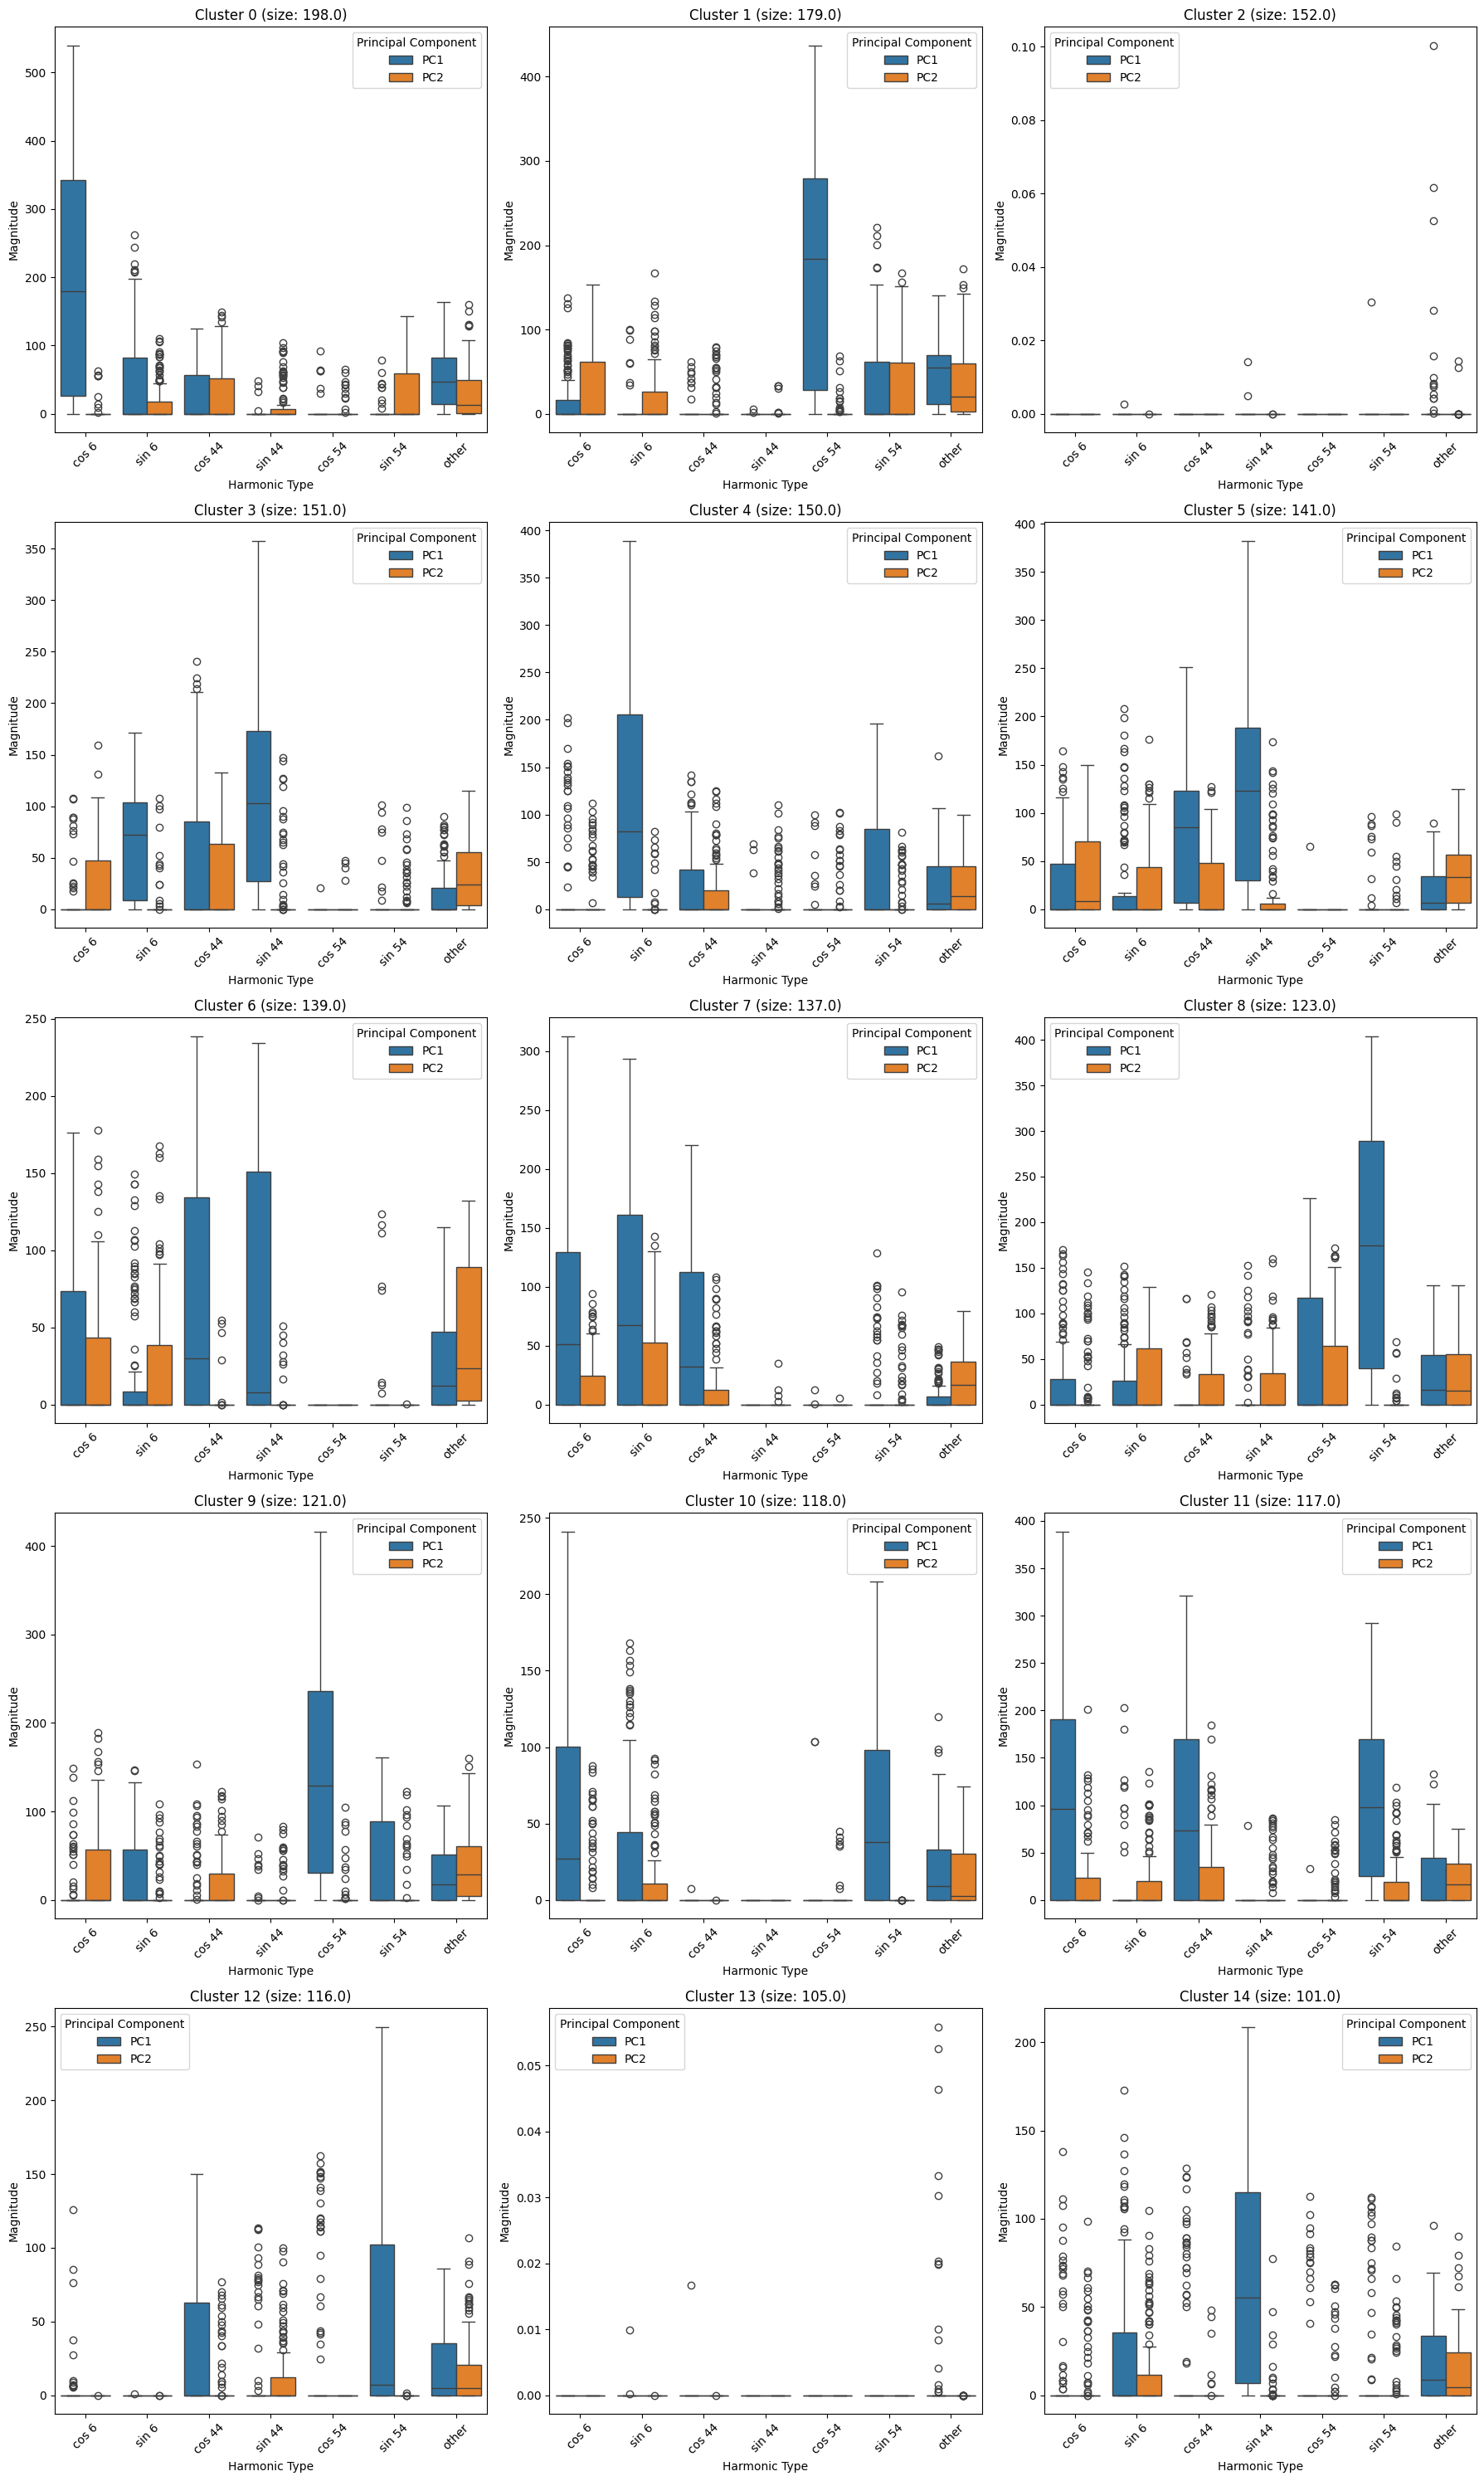

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_indices = sorted(dataframe['cluster index'].unique())
n_clusters = len(cluster_indices)

n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
if n_rows == 1:
    axes = [axes]
if n_cols == 1:
    axes = [[ax] for ax in axes]

pc1_cols = ['pc1_cos 6', 'pc1_sin 6', 'pc1_cos 44', 'pc1_sin 44', 'pc1_cos 54', 'pc1_sin 54', 'pc1_other']
pc2_cols = ['pc2_cos 6', 'pc2_sin 6', 'pc2_cos 44', 'pc2_sin 44', 'pc2_cos 54', 'pc2_sin 54', 'pc2_other']

for idx, cluster_idx in enumerate(cluster_indices):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]
    
    cluster_data = dataframe[dataframe['cluster index'] == cluster_idx]
    
    # Prepare data for PC1 and PC2 separately
    pc1_melted = cluster_data.melt(
        id_vars=['fixed a'], value_vars=pc1_cols,
        var_name='harmonic_type', value_name='magnitude'
    )
    pc1_melted['PC'] = 'PC1'
    pc1_melted['harmonic_type'] = pc1_melted['harmonic_type'].str.replace('pc1_', '')
    
    pc2_melted = cluster_data.melt(
        id_vars=['fixed a'], value_vars=pc2_cols,
        var_name='harmonic_type', value_name='magnitude'
    )
    pc2_melted['PC'] = 'PC2'
    pc2_melted['harmonic_type'] = pc2_melted['harmonic_type'].str.replace('pc2_', '')
    
    # Combine PC1 and PC2 data
    combined_data = pd.concat([pc1_melted, pc2_melted])
    
    # Create grouped box plot
    sns.boxplot(data=combined_data, x='harmonic_type', y='magnitude', hue='PC', ax=ax)
    ax.set_title(f'Cluster {cluster_idx} (size: {cluster_data.iloc[0]["cluster size"]})')
    ax.set_xlabel('Harmonic Type')
    ax.set_ylabel('Magnitude')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Principal Component')

# Remove empty subplots
for idx in range(n_clusters, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row][col])

plt.tight_layout()
plt.show()

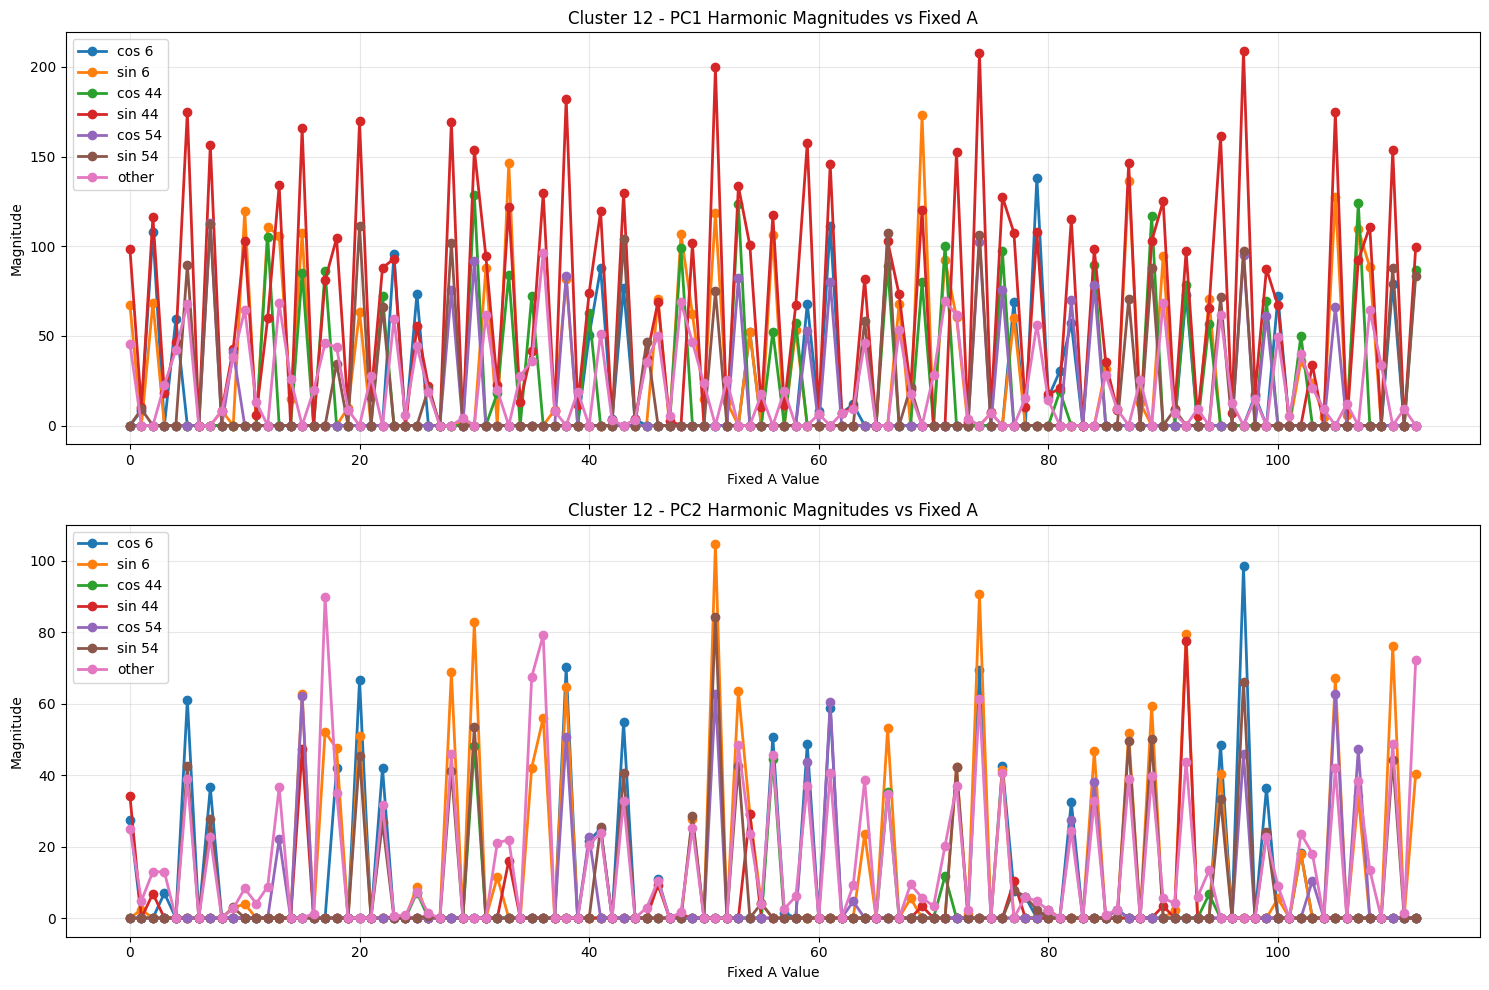

Cluster 12 has 113 different fixed_a values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]
Total data points for cluster 12: 113


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter data for cluster 12 only
cluster_12_data = dataframe[dataframe['cluster index'] == 14].copy()

pc1_cols = ['pc1_cos 6', 'pc1_sin 6', 'pc1_cos 44', 'pc1_sin 44', 'pc1_cos 54', 'pc1_sin 54', 'pc1_other']
pc2_cols = ['pc2_cos 6', 'pc2_sin 6', 'pc2_cos 44', 'pc2_sin 44', 'pc2_cos 54', 'pc2_sin 54', 'pc2_other']

# Alternative: Line plot showing how magnitudes change across fixed_a values
plt.figure(figsize=(15, 10))

# Separate plots for PC1 and PC2
for pc_idx, (pc_cols, pc_name) in enumerate([(pc1_cols, 'PC1'), (pc2_cols, 'PC2')]):
    plt.subplot(2, 1, pc_idx + 1)
    
    for col in pc_cols:
        clean_name = col.replace(f'pc{pc_idx+1}_', '')
        plt.plot(cluster_12_data['fixed a'], cluster_12_data[col], 
                marker='o', label=clean_name, linewidth=2, markersize=6)
    
    plt.xlabel('Fixed A Value')
    plt.ylabel('Magnitude')
    plt.title(f'Cluster 12 - {pc_name} Harmonic Magnitudes vs Fixed A')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Also print some summary info
print(f"Cluster 12 has {len(cluster_12_data['fixed a'].unique())} different fixed_a values: {sorted(cluster_12_data['fixed a'].unique())}")
print(f"Total data points for cluster 12: {len(cluster_12_data)}")

In [30]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import warnings

# Suppress the specific PCA warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn.decomposition._pca')

data_rows = []

for i in range(len(clusters)):
    features_interest = features[:, clusters[i]]
    decoder_interest = decoder[clusters[i], :]
    reconstructions = features_interest @ decoder_interest
    
    for fixed_b in b_values:  # Changed from a_values to b_values
        # Extract data for fixed b across all a values
        indices = [a_idx * 113 + fixed_b for a_idx in range(113)]
        recon_b = reconstructions[indices].detach().cpu().numpy()

        try:
            pca = PCA(n_components=6).fit(recon_b)
            output_pca = pca.transform(recon_b)
            top_freqs = utils.plot_pca_fourier_components(output_pca, plot=False)
        except:
            # If PCA fails, set everything to 0
            row_data = {
                'cluster index': i,
                'cluster size': len(clusters[i]),
                'fixed b': fixed_b,  # Changed from 'fixed a' to 'fixed b'
                'pc1_cos 6': 0, 'pc1_sin 6': 0, 'pc1_cos 44': 0, 'pc1_sin 44': 0, 'pc1_cos 54': 0, 'pc1_sin 54': 0, 'pc1_other': 0,
                'pc2_cos 6': 0, 'pc2_sin 6': 0, 'pc2_cos 44': 0, 'pc2_sin 44': 0, 'pc2_cos 54': 0, 'pc2_sin 54': 0, 'pc2_other': 0
            }
            data_rows.append(row_data)
            continue
        
        # Initialize row data
        row_data = {
            'cluster index': i,
            'cluster size': len(clusters[i]),
            'fixed b': fixed_b,  # Changed from 'fixed a' to 'fixed b'
            'pc1_cos 6': 0, 'pc1_sin 6': 0, 'pc1_cos 44': 0, 'pc1_sin 44': 0, 'pc1_cos 54': 0, 'pc1_sin 54': 0, 'pc1_other': 0,
            'pc2_cos 6': 0, 'pc2_sin 6': 0, 'pc2_cos 44': 0, 'pc2_sin 44': 0, 'pc2_cos 54': 0, 'pc2_sin 54': 0, 'pc2_other': 0
        }
        
        # Process PC1 (component 0) and PC2 (component 1)
        for pc_idx in [0, 1]:  # Only PC1 and PC2
            pc_name = f'pc{pc_idx + 1}'
            
            if pc_idx in top_freqs:
                component_freqs = top_freqs[pc_idx]
                for freq_info in component_freqs:
                    freq = freq_info['frequency']
                    freq_type = freq_info['type']
                    magnitude = freq_info['magnitude']
                    
                    # Check if this matches our target frequencies
                    if freq == 6 and freq_type == 'cos':
                        row_data[f'{pc_name}_cos 6'] = magnitude
                    elif freq == 6 and freq_type == 'sin':
                        row_data[f'{pc_name}_sin 6'] = magnitude
                    elif freq == 44 and freq_type == 'cos':
                        row_data[f'{pc_name}_cos 44'] = magnitude
                    elif freq == 44 and freq_type == 'sin':
                        row_data[f'{pc_name}_sin 44'] = magnitude
                    elif freq == 54 and freq_type == 'cos':
                        row_data[f'{pc_name}_cos 54'] = magnitude
                    elif freq == 54 and freq_type == 'sin':
                        row_data[f'{pc_name}_sin 54'] = magnitude
                    else:
                        row_data[f'{pc_name}_other'] += magnitude
        
        data_rows.append(row_data)

# Create DataFrame from collected data
dataframe_b = pd.DataFrame(data_rows)

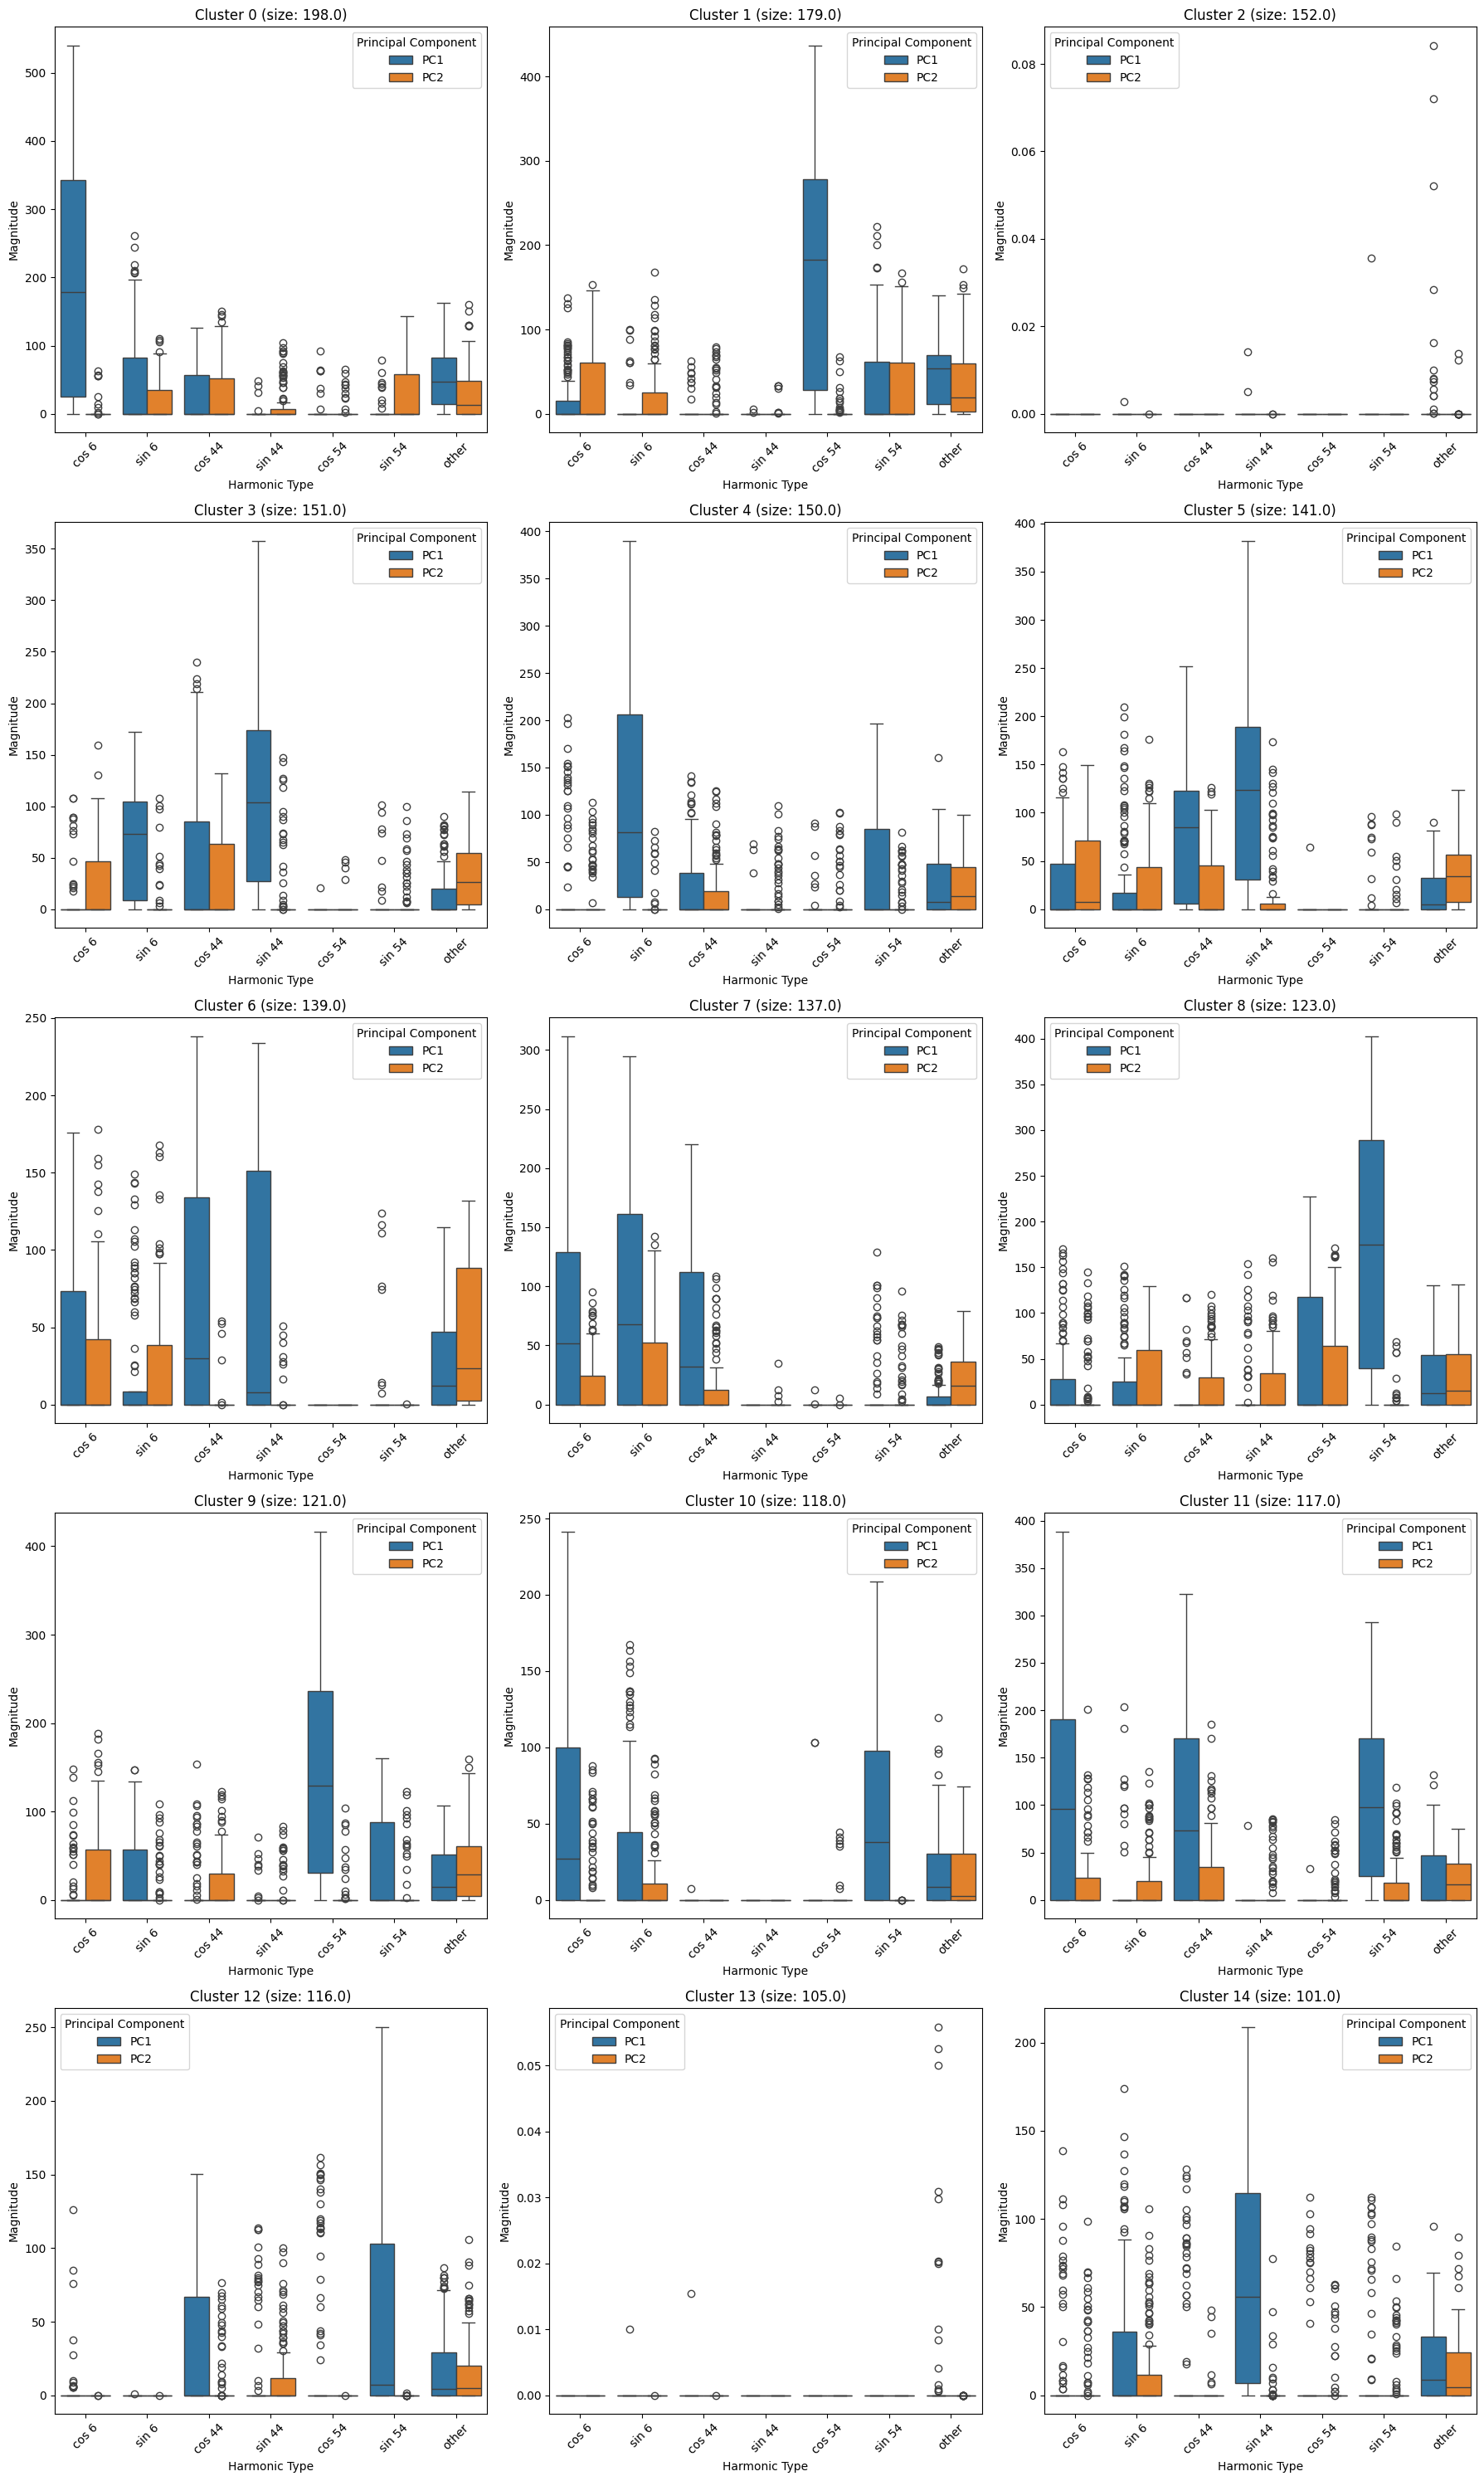

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_indices = sorted(dataframe_b['cluster index'].unique())
n_clusters = len(cluster_indices)

n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
if n_rows == 1:
    axes = [axes]
if n_cols == 1:
    axes = [[ax] for ax in axes]

pc1_cols = ['pc1_cos 6', 'pc1_sin 6', 'pc1_cos 44', 'pc1_sin 44', 'pc1_cos 54', 'pc1_sin 54', 'pc1_other']
pc2_cols = ['pc2_cos 6', 'pc2_sin 6', 'pc2_cos 44', 'pc2_sin 44', 'pc2_cos 54', 'pc2_sin 54', 'pc2_other']

for idx, cluster_idx in enumerate(cluster_indices):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row][col]

    cluster_data = dataframe_b[dataframe_b['cluster index'] == cluster_idx]

    # Prepare data for PC1 and PC2 separately
    pc1_melted = cluster_data.melt(
        id_vars=['fixed b'], value_vars=pc1_cols,
        var_name='harmonic_type', value_name='magnitude'
    )
    pc1_melted['PC'] = 'PC1'
    pc1_melted['harmonic_type'] = pc1_melted['harmonic_type'].str.replace('pc1_', '')
    
    pc2_melted = cluster_data.melt(
        id_vars=['fixed b'], value_vars=pc2_cols,
        var_name='harmonic_type', value_name='magnitude'
    )
    pc2_melted['PC'] = 'PC2'
    pc2_melted['harmonic_type'] = pc2_melted['harmonic_type'].str.replace('pc2_', '')
    
    # Combine PC1 and PC2 data
    combined_data = pd.concat([pc1_melted, pc2_melted])
    
    # Create grouped box plot
    sns.boxplot(data=combined_data, x='harmonic_type', y='magnitude', hue='PC', ax=ax)
    ax.set_title(f'Cluster {cluster_idx} (size: {cluster_data.iloc[0]["cluster size"]})')
    ax.set_xlabel('Harmonic Type')
    ax.set_ylabel('Magnitude')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Principal Component')

# Remove empty subplots
for idx in range(n_clusters, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row][col])

plt.tight_layout()
plt.show()